<a href="https://colab.research.google.com/github/prawnzy-schematics/Coursera/blob/main/OCTID_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -q archive.zip -d dataset


[archive.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of archive.zip or
        archive.zip.zip, and cannot find archive.zip.ZIP, period.


In [ ]:
import os

root = "dataset"
for cls in os.listdir(root):
    p = os.path.join(root, cls)
    if os.path.isdir(p):
        print(cls, "->", len(os.listdir(p)), "images")


OCTID -> 4 images


In [ ]:
data_path = "dataset/OCTID"


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(data_path, transform=train_tf)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

print("Classes:", train_data.classes)
print("Total images:", len(train_data))


Classes: ['CSR', 'DR', 'MH', 'NORMAL']
Total images: 517


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import timm
from sklearn.model_selection import train_test_split
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
data_path = "dataset/OCTID"   # your path
num_classes = 4


In [ ]:
# transforms: resize to 224 (ViT default), use ImageNet normalization
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])


In [ ]:
full_ds = datasets.ImageFolder(data_path, transform=train_tf)  # start with train_tf, we'll swap for val subset
labels = [s[1] for s in full_ds.samples]

train_idx, val_idx = train_test_split(
    list(range(len(labels))),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_ds = Subset(full_ds, train_idx)
# ensure val uses val_tf normalization/transform
val_ds = Subset(datasets.ImageFolder(data_path, transform=val_tf), val_idx)

print("train:", len(train_ds), "val:", len(val_ds))
print("classes:", full_ds.classes)


train: 413 val: 104
classes: ['CSR', 'DR', 'MH', 'NORMAL']


In [ ]:
batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=4)
model.to(device)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [ ]:
criterion = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=15)
  # adjust T_max to epochs


In [ ]:
# === Diagnostic-stabilized training cell ===
import time, numpy as np, torch, math
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR
import torch.nn as nn

# ----------------- Hyperparameters -----------------
EPOCHS = 15
WARMUP_EPOCHS = 3
BACKBONE_LR = 1e-4
HEAD_LR = 1e-3
WEIGHT_DECAY = 1e-2
GRAD_CLIP_NORM = 1.0
LABEL_SMOOTH = 0.1
SAVE_BEST_PATH = "best_model.pth"
# ---------------------------------------------------

use_amp = (device == "cuda")
scaler = torch.amp.GradScaler(enabled=use_amp)

# Rebuild optimizer with differential LR (head vs backbone)
head_params = []
backbone_params = []
for n, p in model.named_parameters():
    if not p.requires_grad:
        continue
    if "head" in n.lower() or "classifier" in n.lower():
        head_params.append(p)
    else:
        backbone_params.append(p)

if len(head_params) == 0:
    # fallback to model.head if available
    try:
        head_params = list(model.head.parameters())
        backbone_params = [p for p in model.parameters() if p not in head_params]
    except Exception:
        head_params = []
        backbone_params = list(model.parameters())

param_groups = [{"params": backbone_params, "lr": BACKBONE_LR}]
if head_params:
    param_groups = [
        {"params": head_params, "lr": HEAD_LR},
        {"params": backbone_params, "lr": BACKBONE_LR},
    ]

opt = torch.optim.AdamW(param_groups, weight_decay=WEIGHT_DECAY)

# Scheduler: cosine over full run + linear warmup multiplier
base_cosine = CosineAnnealingLR(opt, T_max=EPOCHS)
def warmup_lambda(ep):
    if WARMUP_EPOCHS <= 0:
        return 1.0
    return min(1.0, (ep + 1) / float(WARMUP_EPOCHS))
warmup_scheduler = LambdaLR(opt, lr_lambda=warmup_lambda)

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)

# storage
train_losses = []
val_accuracies = []
best_val = 0.0
best_epoch = 0

for epoch in range(EPOCHS):
    t0 = time.time()
    model.train()
    running_loss = 0.0
    total_samples = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).long()

        opt.zero_grad()
        with torch.amp.autocast(device_type="cuda", enabled=use_amp):
            logits = model(imgs)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()

        # AMP: unscale to inspect/clip real gradients
        if use_amp:
            scaler.unscale_(opt)

        # compute raw grad norm (before clipping)
        total_norm_raw = 0.0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm_raw += (param_norm.item() ** 2)
        total_norm_raw = total_norm_raw ** 0.5

        # gradient clipping (in-place)
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)

        # compute clipped grad norm for logging
        total_norm_clipped = 0.0
        for p in model.parameters():
            if p.grad is not None:
                total_norm_clipped += (p.grad.data.norm(2).item() ** 2)
        total_norm_clipped = total_norm_clipped ** 0.5

        scaler.step(opt)
        scaler.update()

        running_loss += float(loss.item()) * imgs.size(0)
        total_samples += imgs.size(0)

    # scheduler stepping: warmup multipliers for first WARMUP_EPOCHS, then cosine
    if epoch < WARMUP_EPOCHS:
        warmup_scheduler.step()
    else:
        base_cosine.step()

    epoch_loss = running_loss / (total_samples if total_samples>0 else 1)
    train_losses.append(epoch_loss)

    # compute train accuracy (cheap full pass)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs_t, labels_t in train_loader:
            imgs_t = imgs_t.to(device)
            labels_t = labels_t.to(device).long()
            with torch.amp.autocast(device_type="cuda", enabled=use_amp):
                logits_t = model(imgs_t)
            preds_t = logits_t.argmax(dim=1)
            correct += (preds_t == labels_t).sum().item()
            total += labels_t.size(0)
    train_acc = correct / total if total>0 else 0.0

    # validation accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs_v, labels_v in val_loader:
            imgs_v = imgs_v.to(device)
            labels_v = labels_v.to(device).long()
            with torch.amp.autocast(device_type="cuda", enabled=use_amp):
                logits_v = model(imgs_v)
            preds_v = logits_v.argmax(dim=1)
            correct += (preds_v == labels_v).sum().item()
            total += labels_v.size(0)
    val_acc = correct / total if total>0 else 0.0
    val_accuracies.append(val_acc)

    # save best
    if val_acc > best_val:
        best_val = val_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), SAVE_BEST_PATH)

    # logging
    current_lr = [g['lr'] for g in opt.param_groups]
    print(
        f"Epoch {epoch+1}/{EPOCHS}  loss={epoch_loss:.4f}  train_acc={train_acc:.4f}  "
        f"val_acc={val_acc:.4f}  lr_backbone={current_lr[-1]:.2e}  lr_head={current_lr[0]:.2e}  "
        f"grad_raw={total_norm_raw:.3f}  grad_clipped={total_norm_clipped:.3f}  time={time.time()-t0:.1f}s"
    )

# final
np.save("train_losses.npy", np.array(train_losses))
np.save("val_accuracies.npy", np.array(val_accuracies))
print(f"Training finished. Best val_acc={best_val:.4f} at epoch {best_epoch}. Saved {SAVE_BEST_PATH}")
# === end diagnostic-stabilized cell ===


Epoch 1/15  loss=1.0728  train_acc=0.9661  val_acc=0.9712  lr_backbone=6.67e-05  lr_head=6.67e-04  grad_raw=4.967  grad_clipped=1.000  time=10.7s
Epoch 2/15  loss=0.5479  train_acc=0.9734  val_acc=0.9038  lr_backbone=1.00e-04  lr_head=1.00e-03  grad_raw=14.102  grad_clipped=1.000  time=8.6s
Epoch 3/15  loss=0.4477  train_acc=0.9758  val_acc=0.9038  lr_backbone=1.00e-04  lr_head=1.00e-03  grad_raw=12.165  grad_clipped=1.000  time=7.9s
Epoch 4/15  loss=0.4276  train_acc=0.9855  val_acc=0.8942  lr_backbone=9.89e-05  lr_head=9.89e-04  grad_raw=5.842  grad_clipped=1.000  time=8.3s
Epoch 5/15  loss=0.3825  train_acc=0.9976  val_acc=0.9615  lr_backbone=9.57e-05  lr_head=9.57e-04  grad_raw=0.668  grad_clipped=0.668  time=8.9s
Epoch 6/15  loss=0.3649  train_acc=0.9831  val_acc=0.9231  lr_backbone=9.05e-05  lr_head=9.05e-04  grad_raw=0.736  grad_clipped=0.736  time=7.9s
Epoch 7/15  loss=0.3734  train_acc=0.9831  val_acc=0.9231  lr_backbone=8.35e-05  lr_head=8.35e-04  grad_raw=0.263  grad_clipped

Loaded best_model.pth

Validation accuracy: 0.9712

Per-class metrics (index, name):
 0  CSR           precision=0.9545  recall=1.0000  f1=0.9767  support=21
 1  DR            precision=0.9130  recall=0.9545  f1=0.9333  support=22
 2  MH            precision=1.0000  recall=0.9000  f1=0.9474  support=20
 3  NORMAL        precision=1.0000  recall=1.0000  f1=1.0000  support=41

Classification Report:

              precision    recall  f1-score   support

         CSR     0.9545    1.0000    0.9767        21
          DR     0.9130    0.9545    0.9333        22
          MH     1.0000    0.9000    0.9474        20
      NORMAL     1.0000    1.0000    1.0000        41

    accuracy                         0.9712       104
   macro avg     0.9669    0.9636    0.9644       104
weighted avg     0.9724    0.9712    0.9711       104



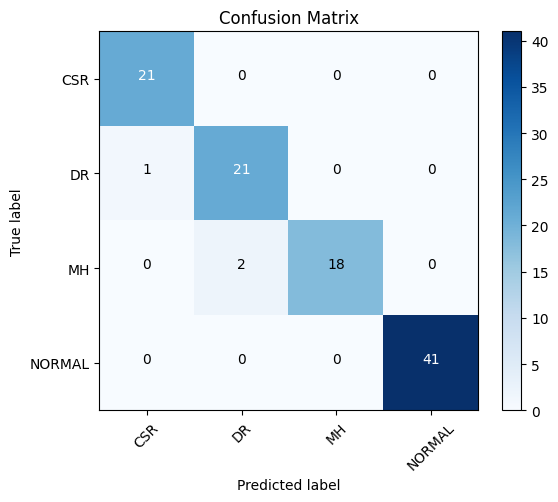

/tmp/ipython-input-1268197482.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10')


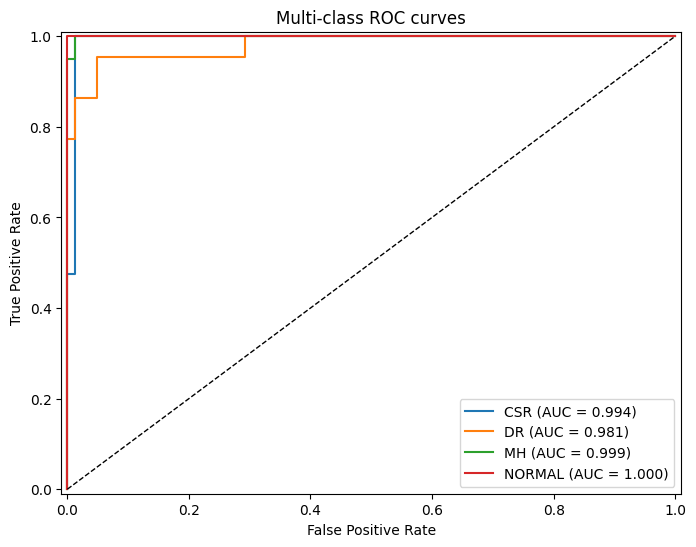

Per-class AUCs: {'CSR': np.float64(0.9937), 'DR': np.float64(0.9812), 'MH': np.float64(0.9994), 'NORMAL': np.float64(1.0)}
Macro AUC: 0.9936


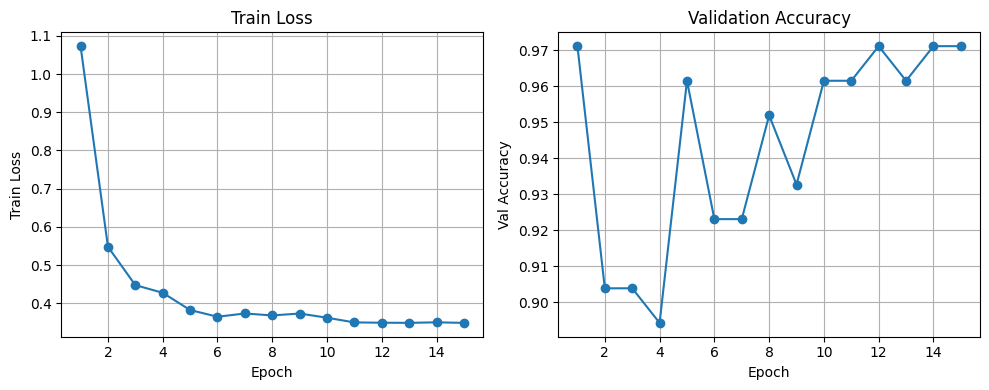

Saved per-class summary to val_summary.csv

Evaluation complete.


In [ ]:
# === CELL B: Evaluation & Plots (run AFTER training finishes) ===
# Precondition: device, val_loader, model, num_classes, class_names exist.
# This cell will load best_model.pth (if present), run inference on val set,
# print metrics (accuracy, per-class precision/recall/f1/support), produce
# confusion matrix, ROC/AUC (per-class + macro), and plot loss/accuracy curves
# saved as train_losses.npy / val_accuracies.npy.

import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_fscore_support,
    classification_report,
    roc_curve,
    auc,
    roc_auc_score,
)
from sklearn.preprocessing import label_binarize
class_names = train_loader.dataset.dataset.classes

# --- load best model if available (optional) ---
if os.path.exists("best_model.pth"):
    sd = torch.load("best_model.pth", map_location=device)
    try:
        model.load_state_dict(sd)
        print("Loaded best_model.pth")
    except Exception as e:
        print("Could not load best_model.pth into model (skipping). Error:", e)

model.to(device)
model.eval()

# --- collect predictions & probabilities on validation set ---
y_true = []
y_pred = []
probs_list = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = logits.argmax(dim=1).cpu().numpy()
        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.tolist())
        probs_list.append(probs)

if len(probs_list) == 0:
    raise RuntimeError("Validation loader produced no batches. Check val_loader.")

probs_all = np.vstack(probs_list)
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --- basic metrics ---
acc = (y_pred == y_true).mean()
print(f"\nValidation accuracy: {acc:.4f}\n")

precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=list(range(num_classes)), zero_division=0
)

print("Per-class metrics (index, name):")
for i, name in enumerate(class_names):
    print(f" {i}  {name:12s}  precision={precision[i]:.4f}  recall={recall[i]:.4f}  f1={f1[i]:.4f}  support={int(support[i])}")

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0, digits=4))

# --- confusion matrix ---
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, class_names, rotation=45)
plt.yticks(ticks, class_names)
thresh = cm.max() / 2. if cm.max() != 0 else 1.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# --- ROC / AUC (multi-class) ---
# Need binarized true labels
try:
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    # compute per-class AUCs and plot ROC curves where possible
    plt.figure(figsize=(8,6))
    colors = plt.cm.get_cmap('tab10')
    per_class_auc = {}
    for c in range(num_classes):
        # skip plotting if only one label present for that class in val set
        if np.unique(y_true_bin[:, c]).size == 1:
            per_class_auc[class_names[c]] = np.nan
            print(f"Class '{class_names[c]}' has only one label present in val set - skipping ROC for this class.")
            continue
        fpr, tpr, _ = roc_curve(y_true_bin[:, c], probs_all[:, c])
        roc_auc = auc(fpr, tpr)
        per_class_auc[class_names[c]] = roc_auc
        plt.plot(fpr, tpr, label=f"{class_names[c]} (AUC = {roc_auc:.3f})", color=colors(c))
    plt.plot([0,1], [0,1], 'k--', lw=1)
    plt.xlim([-0.01,1.01])
    plt.ylim([-0.01,1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC curves')
    plt.legend(loc='lower right')
    plt.show()

    try:
        macro_auc = roc_auc_score(y_true_bin, probs_all, average='macro')
    except Exception:
        macro_auc = np.nan
    print("Per-class AUCs:", {k: (np.nan if np.isnan(v) else round(v,4)) for k,v in per_class_auc.items()})
    print(f"Macro AUC: {macro_auc:.4f}" if not np.isnan(macro_auc) else "Macro AUC: nan")
except Exception as e:
    print("Could not compute ROC/AUC (maybe degenerate class in val set). Error:", e)

# --- Plot loss & accuracy curves if saved arrays exist ---
try:
    train_losses = np.load("train_losses.npy")
    val_accuracies = np.load("val_accuracies.npy")
    epochs_range = np.arange(1, len(train_losses) + 1)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Train Loss")
    plt.title("Train Loss")
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(epochs_range, val_accuracies, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Val Accuracy")
    plt.title("Validation Accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
except Exception:
    print("train_losses.npy or val_accuracies.npy not found or could not be loaded - skipping curves.")

# --- Optional: save a small CSV summary ---
try:
    import csv
    summary_csv = "val_summary.csv"
    with open(summary_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["class", "precision", "recall", "f1", "support", "auc"])
        for i, name in enumerate(class_names):
            auc_val = per_class_auc.get(name, np.nan) if 'per_class_auc' in locals() else np.nan
            writer.writerow([name, precision[i], recall[i], f1[i], int(support[i]), ("" if np.isnan(auc_val) else float(auc_val))])
    print(f"Saved per-class summary to {summary_csv}")
except Exception:
    pass

print("\nEvaluation complete.")


In [ ]:
!ls -lh *.pth


-rw-r--r-- 1 root root 328M Dec  4 12:59 best_model.pth
